# Import Data

In [40]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from scipy import interpolate
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

In [41]:
file_path = r"C:\Users\HuYun\Desktop\Winter_2024\37400\homework 1\treasury_quotes_2023-07-26.xlsx"
rawdata = pd.read_excel(file_path,sheet_name='quotes')
rawdata.head()

,kytreasno,kycrspid_x,caldt,tdbid,tdask,tdnomprc,tdnomprc_flg,tdsourcr,tdaccint,tdretnua,...,tfcaldt,tnotice,iymcn,itype,iuniq,itax,iflwr,tbankdt,tstripelig,tfrgntgt
0,204086,20260215.106000,2023-07-26,103.281250,103.312500,103.296875,M,I,2.668508,0.000894,...,NaN,0,NaN,1,0,1,1,NaN,NaN,NaN
1,204091,20271115.106120,2023-07-26,107.351562,107.421875,107.386719,M,I,1.198370,0.001775,...,NaN,0,NaN,1,0,1,1,NaN,NaN,NaN
2,204095,20290815.106120,2023-07-26,111.070312,111.117188,111.093750,M,I,2.724102,0.003905,...,NaN,0,NaN,1,0,1,1,NaN,NaN,NaN
3,204098,20360215.104500,2023-07-26,107.273438,107.335938,107.304688,M,I,2.001381,0.001331,...,NaN,0,NaN,1,0,1,1,NaN,NaN,NaN
4,204100,20370515.105000,2023-07-26,112.625000,112.687500,112.656250,M,I,0.978261,0.001152,...,NaN,0,NaN,1,0,1,1,NaN,NaN,NaN


In [42]:
rawdata.sort_values('tmatdt',inplace=True)
rawdata.set_index('kytreasno',inplace=True)

In [43]:
# check if quotes are from the same dates
is_same = rawdata['caldt'].nunique() == 1
print(f'Is the data from the same date? {is_same}')

Is the data from the same date? True


In [44]:
t_current = rawdata['caldt'].values[0]
f'Analysis based on quotes from: {pd.to_datetime(t_current):%Y-%m-%d}'

'Analysis based on quotes from: 2023-07-26'

In [45]:
metrics = rawdata.copy()[['tdatdt','tmatdt','tcouprt','tdyld','tdduratn','tdpubout']]
metrics.columns = ['issue date','maturity date','coupon rate','TDYLD','duration','outstanding']
metrics['TDYLD'] *= 365
metrics['duration'] /= 365
metrics['outstanding'] *= 1e6
metrics['ask-bid'] = rawdata['tdask'] - rawdata['tdbid']
metrics.head()

,issue date,maturity date,coupon rate,TDYLD,duration,outstanding,ask-bid
kytreasno,,,,,,,
207997,2023-01-26,2023-07-27,0.000,0.050698,0.002740,NaN,0.000028
207231,2018-07-31,2023-07-31,2.750,0.027357,0.013699,2.331900e+10,0.031250
207742,2021-07-31,2023-07-31,0.125,0.032614,0.013699,5.589300e+10,0.039062
206998,2016-07-31,2023-07-31,1.250,0.043711,0.013699,2.575100e+10,0.039062
208025,2023-04-04,2023-08-01,0.000,0.051730,0.016438,NaN,0.000167


# Problem 1: Explore the Data

## 1 Maturity

In [46]:
#def time_to_maturity(t_maturity, t_current):
    
    #return t_maturity.apply(lambda x: (x - t_current).days / 365.25)

def time_to_maturity(t_maturity, t_current):
    maturity_delta = (t_maturity - t_current) / pd.Timedelta('365.25 days')
    
    return maturity_delta


metrics['maturity date'] = pd.to_datetime(metrics['maturity date'])
metrics['maturity'] = time_to_maturity(metrics['maturity date'], t_current)

summary_maturity = metrics['maturity'].describe()
summary_maturity


count    437.000000
mean       6.647571
std        8.176720
min        0.002738
25%        1.056810
50%        3.181383
75%        7.055441
max       29.637235
Name: maturity, dtype: float64

## 2 Prices 

In [47]:
metrics['price'] = (rawdata['tdbid'] + rawdata['tdask'])/2 + rawdata['tdaccint']
metrics['price'].head()

kytreasno
207997     99.986111
207231    101.337017
207742    100.017805
206998    100.564766
208025     99.915000
Name: price, dtype: float64

## 3 YTM

In [48]:
from scipy.optimize import fsolve

def pv(rate, cashflows, maturities,freq=1):
    price = sum([cfi/(1+rate/freq)**(maturities[i]*freq) for i, cfi in enumerate(cashflows)])
    return price

In [49]:
def filter_treasuries(data, t_date=None, filter_maturity = None, filter_maturity_min=None, drop_duplicate_maturities = False, filter_tips=True, filter_yld=True):
    outdata = data.copy()
    
    if t_date is None:
        t_date = outdata['caldt'].values[-1]
    
    outdata = outdata[outdata['caldt']==t_date]
    
    # Filter out redundant maturity
    if drop_duplicate_maturities:
        outdata = outdata.drop_duplicates(subset=['tmatdt'])
    
    # Filter by max maturity
    if filter_maturity is not None:
        mask_truncate = outdata['tmatdt'] < (t_date + np.timedelta64(365*filter_maturity+1,'D'))
        outdata = outdata[mask_truncate]

    # Filter by min maturity
    if filter_maturity_min is not None:
        mask_truncate = outdata['tmatdt'] > (t_date + np.timedelta64(365*filter_maturity_min-1,'D'))
        outdata = outdata[mask_truncate]

    outdata = outdata[outdata['itype'].isin([11,12]) == (not filter_tips)]
        
    if filter_yld:
        outdata = outdata[outdata['tdyld']>0]
        
    return outdata

In [50]:
def get_coupon_dates(quote_date,maturity_date):

    if isinstance(quote_date,str):
        quote_date = datetime.datetime.strptime(quote_date,'%Y-%m-%d')
        
    if isinstance(maturity_date,str):
        maturity_date = datetime.datetime.strptime(maturity_date,'%Y-%m-%d')
    
    # divide by 180 just to be safe
    temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
    # filter out if one date too many
    temp = pd.DataFrame(data=temp[temp > quote_date])

    out = temp[0]
    return out

In [51]:
def filter_treasury_cashflows(CF, filter_maturity_dates=False, filter_benchmark_dates=False, filter_CF_strict=True):

    mask_benchmark_dts = []
    
    # Filter by using only benchmark treasury dates
    for col in CF.columns:
        if filter_benchmark_dates:
            if col.month in [2,5,8,11] and col.day == 15:
                mask_benchmark_dts.append(col)
        else:
            mask_benchmark_dts.append(col)
    
    if filter_maturity_dates:
        mask_maturity_dts = CF.columns[(CF>=100).any()]
    else:
        mask_maturity_dts = CF.columns
    
    mask = [i for i in mask_benchmark_dts if i in mask_maturity_dts]

    CF_filtered = CF[mask]
          
    if filter_CF_strict:
        # drop issues that had CF on excluded dates
        mask_bnds = CF_filtered.sum(axis=1) == CF.sum(axis=1)
        CF_filtered = CF_filtered[mask_bnds]

    else:
        # drop issues that have no CF on included dates
        mask_bnds = CF_filtered.sum(axis=1) > 0
        CF_filtered = CF_filtered[mask_bnds]
        
        
    # update to drop dates with no CF
    CF_filtered = CF_filtered.loc[:,(CF_filtered>0).any()]
    
    return CF_filtered


In [52]:
def calc_cashflows(quote_data, filter_maturity_dates=False):
    
    CF = pd.DataFrame(data=0, index=quote_data.index, columns=quote_data['tmatdt'].unique())

    for i in quote_data.index:
        coupon_dates = get_coupon_dates(quote_data.loc[i,'caldt'],quote_data.loc[i,'tmatdt'])

        if coupon_dates is not None:
            CF.loc[i,coupon_dates] = quote_data.loc[i,'tcouprt']/2

        CF.loc[i,quote_data.loc[i,'tmatdt']] += 100


    CF = CF.fillna(0).sort_index(axis=1)
    CF.drop(columns=CF.columns[(CF==0).all()],inplace=True)

    if filter_maturity_dates:
        CF = filter_treasury_cashflows(CF, filter_maturity_dates=True)
        
    return CF

In [53]:
def compound_rate(intrate,compound_input,compound_output):
    
#    outrate = intrate[['maturity']]
    
    if compound_input is None:
        outrate = compound_output * (np.exp(intrate/compound_output) - 1)
    elif compound_output is None:
        outrate = compound_input * np.log(1 + intrate/compound_input)
    else:
        outrate = ((1 + intrate/compound_input) ** (compound_input/compound_output) - 1) * compound_output

    return outrate

In [54]:
RESTRICT_YLD = False
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

In [55]:
CF

,2023-07-27,2023-07-31,2023-08-01,2023-08-03,2023-08-08,2023-08-10,2023-08-15,2023-08-17,2023-08-22,2023-08-24,...,2051-09-15,2051-11-15,2052-02-15,2052-03-15,2052-05-15,2052-08-15,2052-09-15,2052-11-15,2053-02-15,2053-03-15
kytreasno,,,,,,,,,,,,,,,,,,,,,
207997,100,0.0000,0,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
207231,0,101.3750,0,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
207742,0,100.0625,0,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
206998,0,100.6250,0,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
208025,0,0.0000,100,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207891,0,0.0000,0,0,0,0,0.0000,0,0,0,...,0.0000,1.4375,0.0000,0.0000,101.4375,0.0000,0.0000,0,0.0000,0.0000
207934,0,0.0000,0,0,0,0,1.5000,0,0,0,...,0.0000,0.0000,1.5000,0.0000,0.0000,101.5000,0.0000,0,0.0000,0.0000
207977,0,0.0000,0,0,0,0,0.0000,0,0,0,...,0.0000,2.0000,0.0000,0.0000,2.0000,0.0000,0.0000,102,0.0000,0.0000


In [56]:
px = (rawdata[['tdask','tdbid']].mean(axis=1) + rawdata['tdaccint']).loc[CF.index]
maturity_grid = pd.Series(time_to_maturity(CF.columns.values,t_current=t_current),index=CF.columns)

ytm = pd.DataFrame(index=px.index,columns=['annual','semiannual','daily','continuous'],dtype=float)
for idbond in px.index:
    pv_wrapper = lambda y: px.loc[idbond] - pv(y,CF.loc[idbond,:].values,maturity_grid.values,freq=2)
    ytm.loc[idbond,'semiannual'] = fsolve(pv_wrapper,.01)

ytm['annual'] = compound_rate(ytm['semiannual'],2,1)
ytm['daily'] = compound_rate(ytm['semiannual'],2,365)
ytm['continuous'] = compound_rate(ytm['semiannual'],2,None)
ytm

,annual,semiannual,daily,continuous
kytreasno,,,,
207997,0.052042,0.051382,0.050736,0.050733
207231,0.027754,0.027564,0.027377,0.027376
207742,0.033175,0.032905,0.032638,0.032637
206998,0.044711,0.044223,0.043743,0.043741
208025,0.053129,0.052441,0.051769,0.051766
...,...,...,...,...
207891,0.039909,0.039519,0.039136,0.039133
207934,0.039882,0.039492,0.039109,0.039107
207977,0.039688,0.039301,0.038922,0.038920


In [57]:
COMPOUND_FREQ = 'continuous'

table = metrics.copy()
table = table[['maturity','price','coupon rate','TDYLD','ask-bid']]
table.insert(4,'ytm',ytm[COMPOUND_FREQ])
table

,maturity,price,coupon rate,TDYLD,ytm,ask-bid
kytreasno,,,,,,
207997,0.002738,99.986111,0.000,0.050698,0.050733,0.000028
207231,0.013689,101.337017,2.750,0.027357,0.027376,0.031250
207742,0.013689,100.017805,0.125,0.032614,0.032637,0.039062
206998,0.013689,100.564766,1.250,0.043711,0.043741,0.039062
208025,0.016427,99.915000,0.000,0.051730,0.051766,0.000167
...,...,...,...,...,...,...
207934,29.056810,85.006129,3.000,0.039081,0.039107,0.046875
207977,29.308693,101.977921,4.000,0.038894,0.038920,0.015625
208020,29.560575,96.466797,1.500,NaN,NaN,0.332031


In [58]:
table.describe()

,maturity,price,coupon rate,TDYLD,ytm,ask-bid
count,437.000000,437.000000,437.000000,386.000000,386.000000,437.000000
mean,6.647571,94.190181,2.039188,0.045833,0.045913,0.045396
std,8.176720,8.935293,1.619633,0.005614,0.005653,0.043034
min,0.002738,55.518003,0.000000,0.027357,0.027376,0.000028
25%,1.056810,90.371094,0.500000,0.040858,0.040923,0.031250
50%,3.181383,96.466797,2.000000,0.044400,0.044571,0.031250
75%,7.055441,99.052649,3.000000,0.051866,0.051922,0.046875
max,29.637235,114.621264,7.625000,0.054213,0.059957,0.332031


## 4 Plots

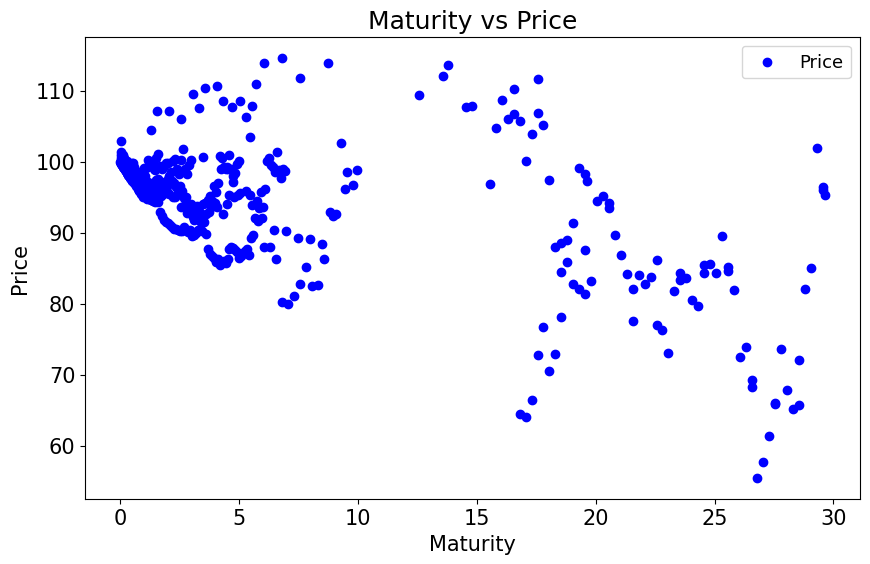

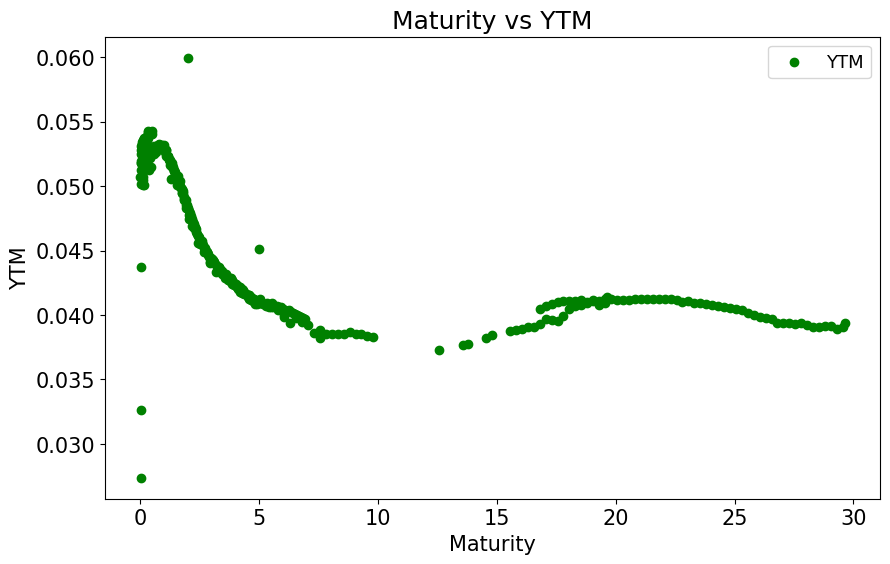

In [59]:
plt.figure(figsize=(10, 6))
plt.scatter(table['maturity'], table['price'], c='blue', label='Price')
plt.title('Maturity vs Price')
plt.xlabel('Maturity')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(table['maturity'], table['ytm'], c='green', label='YTM')
plt.title('Maturity vs YTM')
plt.xlabel('Maturity')
plt.ylabel('YTM')
plt.legend()
plt.show()

## 5 Bad data

In [60]:
nan_issues = table[pd.isna(table['TDYLD'])]
affected_rows = len(nan_issues)
print(f"affected_rows: {affected_rows}")
print(nan_issues)

affected_rows: 51
            maturity       price  coupon rate  TDYLD  ytm   ask-bid
kytreasno                                                          
206701      0.473648   98.386719        0.625    NaN  NaN  0.007812
207348      0.722793   97.580078        0.500    NaN  NaN  0.011719
206759      0.971937   97.017578        0.125    NaN  NaN  0.011719
207431      1.223819   96.402344        0.125    NaN  NaN  0.015625
206816      1.475702   95.802734        0.250    NaN  NaN  0.019531
206468      1.475702   98.767578        2.375    NaN  NaN  0.019531
207528      1.722108   95.175781        0.125    NaN  NaN  0.023438
206878      1.971253   95.664062        0.375    NaN  NaN  0.023438
207623      2.223135   94.998047        0.125    NaN  NaN  0.027344
206480      2.475017   98.718750        2.000    NaN  NaN  0.031250
206941      2.475017   95.472656        0.625    NaN  NaN  0.031250
207702      2.721424   93.958984        0.125    NaN  NaN  0.035156
206999      2.970568   94.0996

The gap between ask and bid is too large. We can use this metric to know that there is a problem with the price.

# Problem 2: Extract the Discount Curve

## 1 Map Cashflows

In [61]:
CF = calc_cashflows(rawdata)
prices = metrics['price'][CF.index]

CFset = {'all dates, including negative YTM quotes':CF}
display(CF)

,2023-07-27,2023-07-31,2023-08-01,2023-08-03,2023-08-08,2023-08-10,2023-08-15,2023-08-17,2023-08-22,2023-08-24,...,2051-09-15,2051-11-15,2052-02-15,2052-03-15,2052-05-15,2052-08-15,2052-09-15,2052-11-15,2053-02-15,2053-03-15
kytreasno,,,,,,,,,,,,,,,,,,,,,
207997,100,0.0000,0,0,0,0,0.0000,0,0,0,...,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0,0.0000,0.0000
207231,0,101.3750,0,0,0,0,0.0000,0,0,0,...,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0,0.0000,0.0000
207742,0,100.0625,0,0,0,0,0.0000,0,0,0,...,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0,0.0000,0.0000
206998,0,100.6250,0,0,0,0,0.0000,0,0,0,...,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0,0.0000,0.0000
208025,0,0.0000,100,0,0,0,0.0000,0,0,0,...,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207934,0,0.0000,0,0,0,0,1.5000,0,0,0,...,0.0000,0.0,1.5000,0.0000,0.0,101.5000,0.0000,0,0.0000,0.0000
207977,0,0.0000,0,0,0,0,0.0000,0,0,0,...,0.0000,2.0,0.0000,0.0000,2.0,0.0000,0.0000,102,0.0000,0.0000
208020,0,0.0000,0,0,0,0,0.7500,0,0,0,...,0.0000,0.0,0.7500,0.0000,0.0,0.7500,0.0000,0,100.7500,0.0000


In [62]:
total_cashflow_per_date = CF.sum()
date_most_cashflow = total_cashflow_per_date.idxmax()
print("Date：", date_most_cashflow, "the most cashflow：", total_cashflow_per_date[date_most_cashflow])

count_bonds_paying_per_date = (CF != 0).sum()
date_most_bonds_paying = count_bonds_paying_per_date.idxmax()
print("Date：", date_most_bonds_paying, "the most issue：", count_bonds_paying_per_date[date_most_bonds_paying])

Date： 2023-08-15 00:00:00 the most cashflow： 524.5
Date： 2023-08-15 00:00:00 the most issue： 90


## 2 BootStrap

In [63]:
def estimate_curve_ols(CF,prices,interpolate=False):

    if isinstance(prices,pd.DataFrame) or isinstance(prices,pd.Series):
        prices = prices[CF.index].values
    
    mod = LinearRegression(fit_intercept=False).fit(CF.values,prices)

    if interpolate:
        matgrid = time_to_maturity(CF.columns,CF.columns.min())

        dts_valid = np.logical_and(mod.coef_<1.25, mod.coef_>0)

        xold = matgrid[dts_valid]
        xnew = matgrid
        yold = mod.coef_[dts_valid]

        f = interpolate.interp1d(xold, yold, bounds_error=False, fill_value='extrapolate')    
        discounts = f(xnew)

    else:
        discounts = mod.coef_    
        
    return discounts

In [64]:
def nelson_siegel(params,maturity):
    rate = params[0] + (params[1] + params[2]) * (1 - np.exp(-maturity/params[3]))/(maturity/params[3]) - params[2] * np.exp(-maturity/params[3])
    
    return rate
def nelson_siegel_extended(params,maturity):
    rate = params[0] + (params[1] + params[2]) * (1 - np.exp(-maturity/params[3]))/(maturity/params[3]) - params[2] * np.exp(-maturity/params[3]) + params[4] *((1-np.exp(-maturity/params[5]))/(maturity/params[5]) - np.exp(-maturity/params[5]))
    
    return rate

In [65]:
def intrate_to_discount(intrate, maturity, n_compound=None):
    
    if n_compound is None:
        discount = np.exp(-intrate * maturity)
    else:
        discount = 1 / (1+(intrate / n_compound))**(n_compound * maturity)

    return discount    

In [66]:
def price_with_rate_model(params,CF,t_current,fun_model, convert_to_discount=True, price_coupons=False):

    maturity = time_to_maturity(CF.columns, t_current)
    
    if convert_to_discount:
        disc = np.zeros(maturity.shape)
        for i, mat in enumerate(maturity):
            disc[i] = intrate_to_discount(fun_model(params,mat),mat)
    else:
        disc = fun(params,mat)
        
        
    if price_coupons:
        price = CF * disc
    else:
        price = CF @ disc
    
    return price

In [67]:
def pricing_errors(params,CF,t_current,fun_model,observed_prices):

    price_modeled = price_with_rate_model(params,CF,t_current,fun_model)

    if isinstance(observed_prices,pd.DataFrame) or isinstance(observed_prices,pd.Series):
        observed_prices = observed_prices.values
        
    error = sum((observed_prices - price_modeled)**2)
    
    return error

In [68]:
def estimate_rate_curve(model,CF,t_current,prices,x0=None):

    if model is bootstrap:
        params = estimate_curve_ols(CF,prices,interpolate=False)
        
        CF_intervals = time_to_maturity(CF.columns.to_series(),t_current=t_current).values
    
        params_optimized = [CF_intervals,params]

    else:
        if x0 is None:
            if model is nelson_siegel:
                x0 = np.ones(4)/10
            elif model is nelson_siegel_extended:
                x0 = np.ones(6)
            else:
                x0 = 1        

        mod = minimize(pricing_errors, x0, args=(CF, t_current, model, prices))
        params_optimized = mod.x

    return params_optimized

In [69]:

def discount_to_intrate(discount, maturity, n_compound=None):
        
    if n_compound is None:
        intrate = - np.log(discount) / maturity
    
    else:
        intrate = n_compound * (1/discount**(1/(n_compound * maturity)) - 1)    
        
    return intrate

In [70]:
def bootstrap(params,maturity,n_compound):
    estimated_maturities = params[0]
    betas = params[1]
    estimated_rates = discount_to_intrate(betas,estimated_maturities,n_compound)
    
    f = interpolate.interp1d(estimated_maturities, estimated_rates, bounds_error=False, fill_value='extrapolate')
    
    rate = f(maturity)

    return rate

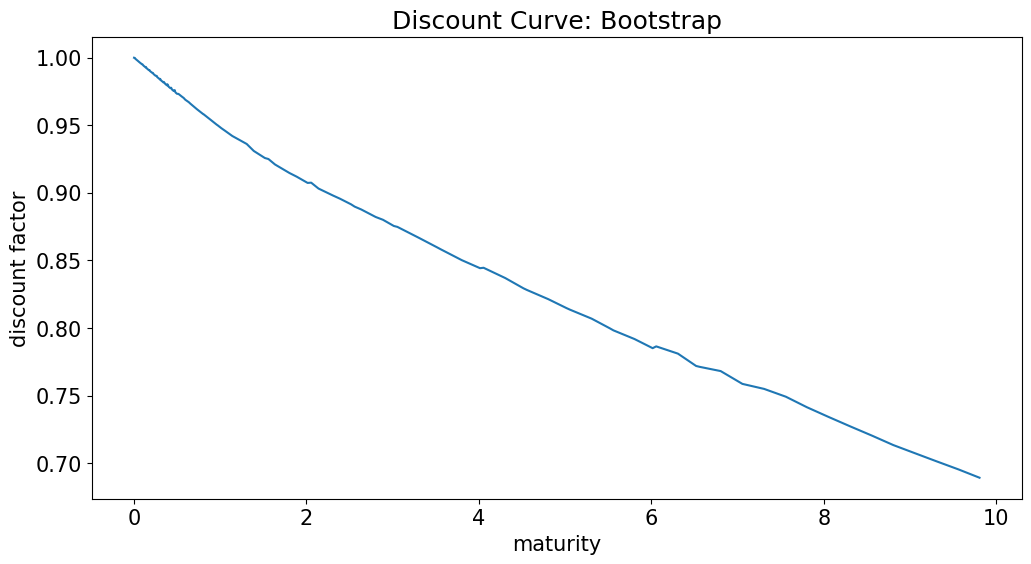

In [71]:
MODEL = bootstrap

RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = True

data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

prices = metrics['price'][CF.index]
 = estimate_rate_curve(MODEL,CF,t_current,prices)

label = 'single maturity per date, no non-maturity dates'
CFset[label] = CF

plt.plot(params_boot[0],params_boot[1])
plt.xlabel('maturity')
plt.ylabel('discount factor')
plt.title('Discount Curve: Bootstrap')
plt.show()

## 3. OLS

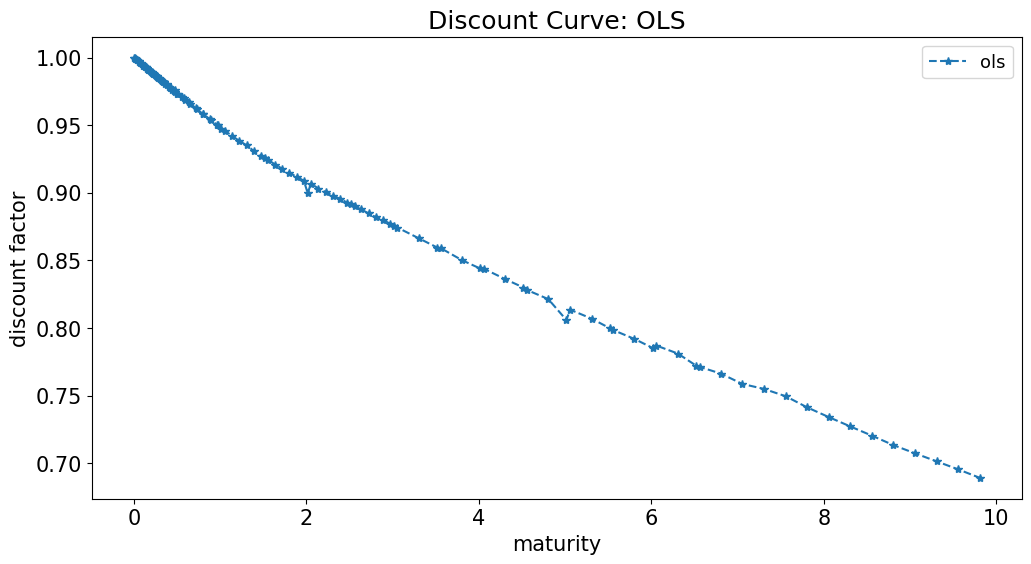

In [72]:
MODEL = bootstrap

RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

prices = metrics['price'][CF.index]
params_OLS = estimate_rate_curve(MODEL,CF,t_current,prices)

label = 'no non-maturity dates'
CFset[label] = CF

disc_ols = pd.DataFrame({'maturity':params_OLS[0], 'ols': params_OLS[1]}).set_index('maturity')
disc_ols.plot(marker='*',linestyle='--',ylabel='discount factor',title='Discount Curve: OLS')
plt.show()

## 4 Factors and Rates

### continuous discount rates

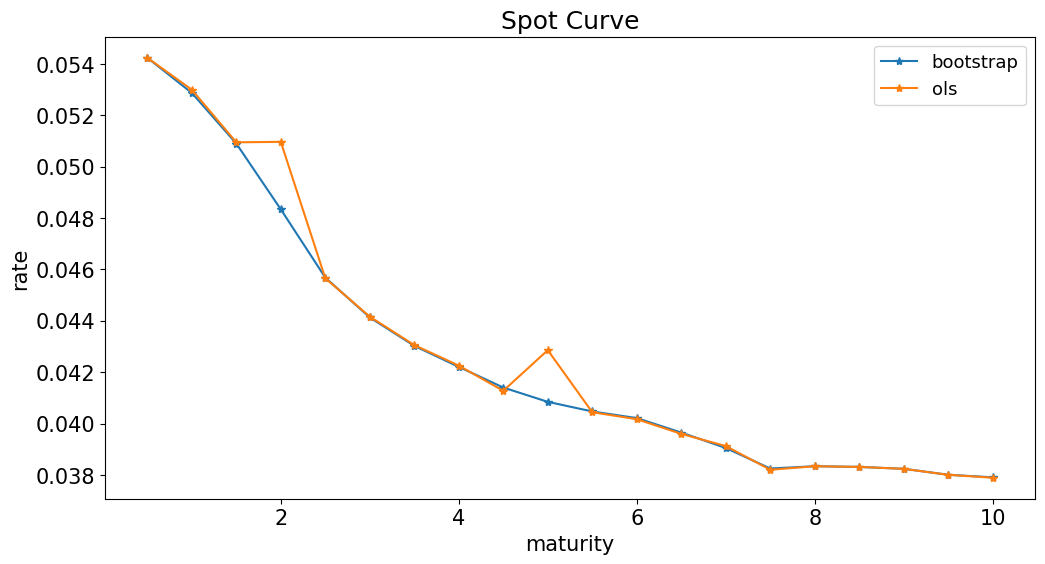

In [73]:
inc = .5

maturity_grid = np.arange(inc,disc_ols.index.to_series().max()+.5,inc)
curves_ols = pd.DataFrame(index = maturity_grid)
curves_ols['bootstrap'] = bootstrap(params_boot,maturity_grid,n_compound=None)
curves_ols['ols'] = bootstrap(params_OLS,maturity_grid,n_compound=None)

ax = curves_ols.plot(linestyle='-',marker='*',ylabel='rate',xlabel='maturity',title='Spot Curve')
plt.show()

### semiannually compounded discount rates

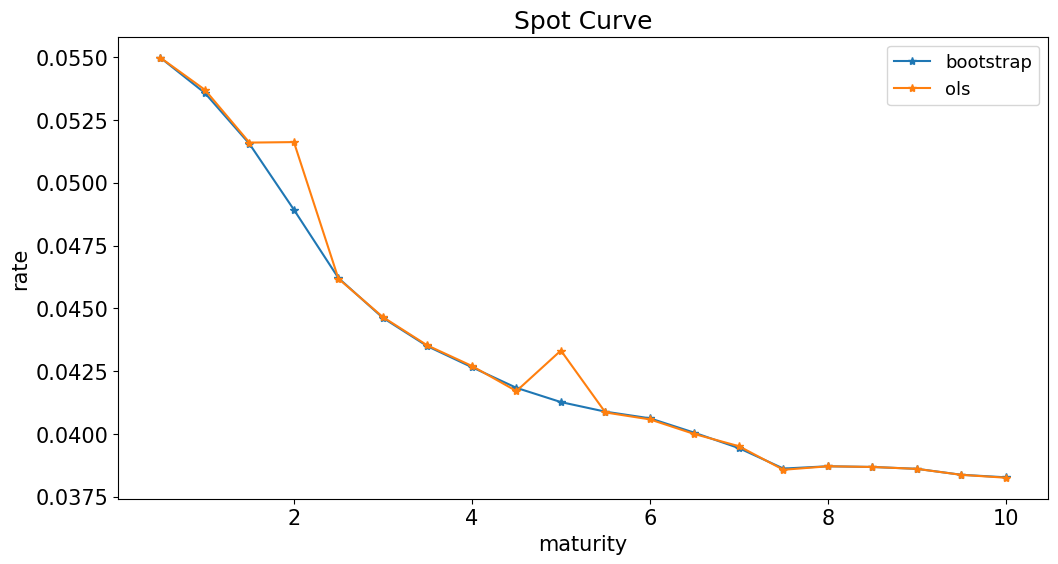

In [74]:
inc = .5

maturity_grid = np.arange(inc,disc_ols.index.to_series().max()+.5,inc)
curves_ols = pd.DataFrame(index = maturity_grid)
curves_ols['bootstrap'] = bootstrap(params_boot,maturity_grid,n_compound=2)
curves_ols['ols'] = bootstrap(params_OLS,maturity_grid,n_compound=2)

ax = curves_ols.plot(linestyle='-',marker='*',ylabel='rate',xlabel='maturity',title='Spot Curve')
plt.show()


# Problem 3: Nelson-Siegel Curve

In [75]:
prices = metrics['price'][CF.index]

x0 = np.ones((4))/10
params_NS = estimate_rate_curve(nelson_siegel,CF,t_current,prices,x0)

x0 = np.concatenate((params_NS,(2,2)))
params_NSE = estimate_rate_curve(nelson_siegel_extended,CF,t_current,prices,x0=x0)

tab_params_ns = pd.DataFrame(data = params_NS, index=['theta 0', 'theta 1', 'theta 2', 'lambda_1'],columns=['Nelson-Siegel']).T
tab_params_ns.loc[:,['theta_3', 'lambda_2']] = None
tab_params_ns.loc['Nelson-Siegel Extended',:] = params_NSE
tab_params_ns

C:\Users\HuYun\AppData\Local\Temp\ipykernel_18896\2754424223.py:4: RuntimeWarning: overflow encountered in exp
  discount = np.exp(-intrate * maturity)
C:\Users\HuYun\AppData\Local\Temp\ipykernel_18896\2754424223.py:4: RuntimeWarning: overflow encountered in exp
  discount = np.exp(-intrate * maturity)
C:\Users\HuYun\AppData\Local\Temp\ipykernel_18896\2754424223.py:4: RuntimeWarning: overflow encountered in exp
  discount = np.exp(-intrate * maturity)
C:\Users\HuYun\AppData\Local\Temp\ipykernel_18896\944359609.py:6: RuntimeWarning: overflow encountered in exp
  rate = params[0] + (params[1] + params[2]) * (1 - np.exp(-maturity/params[3]))/(maturity/params[3]) - params[2] * np.exp(-maturity/params[3]) + params[4] *((1-np.exp(-maturity/params[5]))/(maturity/params[5]) - np.exp(-maturity/params[5]))
C:\Users\HuYun\AppData\Local\Temp\ipykernel_18896\944359609.py:6: RuntimeWarning: invalid value encountered in scalar subtract
  rate = params[0] + (params[1] + params[2]) * (1 - np.exp(-matur

,theta 0,theta 1,theta 2,lambda_1,theta_3,lambda_2
Nelson-Siegel,0.020064,0.09779,0.09784,0.095789,None,None
Nelson-Siegel Extended,0.020064,0.09779,0.09784,0.095789,2.0,2.0


### Plot the estimated discount factors, $\textbf{z}_{\text{ns}}$ against time-to-maturity.

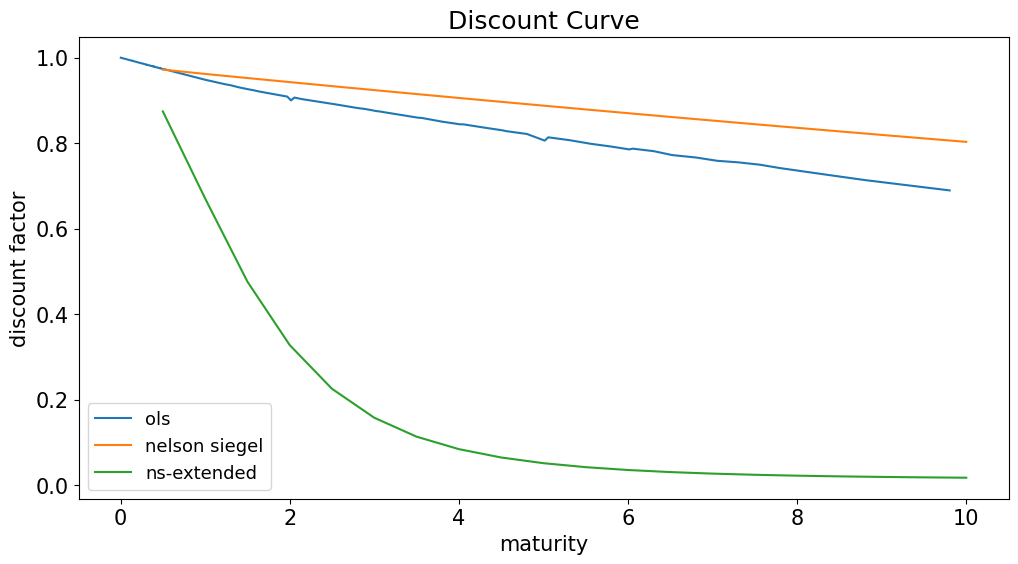

In [85]:
ax = disc_ols.plot()

zero_curve = intrate_to_discount(curves.loc[:,'nelson siegel'], maturity_grid, n_compound=None).to_frame()
zero_curve['ns-extended'] = intrate_to_discount(curves.loc[:,'ns-extended'], maturity_grid, n_compound=None).to_frame()
zero_curve.plot(ax=ax, title='Discount Curve', xlabel='maturity',ylabel='discount factor')

plt.show()

### Also plot the associated continuously-compounded discount rates.

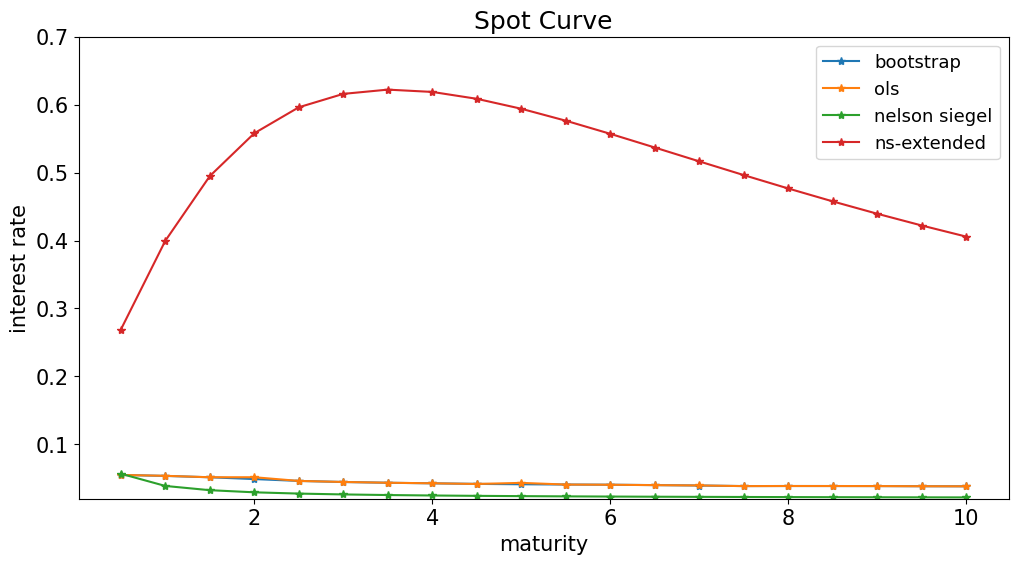

In [84]:
inc = .5

maturity_list = time_to_maturity(list(CFset.values())[-1].columns,t_current=t_current)
maturity_grid = np.arange(inc,maturity_list.max()+.5,inc)
curves = pd.DataFrame(index = maturity_grid)
curves['nelson siegel'] = nelson_siegel(params_NS,maturity_grid)
curves['ns-extended']= nelson_siegel_extended(params_NSE,maturity_grid)

ax = curves_ols.plot(linestyle='-',marker='*')
curves.plot(ax=ax, linestyle='-',marker='*', ylim=(0,1.1*curves.max().max()*1.1))

series_plotted = list(curves_ols.columns) + list(curves.columns)
plt.legend(series_plotted)
plt.ylim(.02,0.7)
plt.xlabel('maturity')
plt.ylabel('interest rate')
plt.title('Spot Curve')
plt.show()